In [1]:
import numpy as np
import pandas as pd
import pyreadr     # to read Rdata files
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae

### Load predictor and target variable data for 1980-2020

In [2]:
# data will be a dictionary where keys are the name of objects and the values python objects
data = pyreadr.read_r('/Users/hauke/Ironhack/GitHub/Labs/Week_5_Midterm_Project/data/predictors_testdata_detr_stand_AC.Rdata') # also works for Rds
# print(data.keys())

# extract variable data (only Northern hemisphere), for years 1980/81 - 2020/21
sst = data["SST_AC"][:,96:,:]           # sea surface temperature
sit = data["SIT_sepoct_AC"][:,96:,:]    # sea ice (mean of september and october)
snd = data["SND_AC"][:,96:,:]           # snow depth
ta = data["TA_AC"][:,96:,:]             # stratospheric temperature in 100 hPa height
NAO = data["NAO"]                       # North Atlantic Oscillation index

#### Cut geographical regions

In [3]:
# exclude everything outside of Northern Atlantic for the SST predictor
lon1 = 106
lon2 = 202
lat1 = 0
lat2 = 69
for lon in np.arange(0,384):
    for lat in np.arange(0,96):
        if lon<lon1 or lon>lon2 or lat<lat1 or lat>lat2:
            sst[lon,lat,:] = None

In [4]:
# exclude everything outside of 40-90N/50-150E for the snow predictor
lon1 = 244
lon2 = 351
lat1 = 138
lat2 = 191
for lon in np.arange(0,384):
    for lat in np.arange(0,96):
        if lon<lon1 or lon>lon2 or lat<lat1 or lat>lat2:
            snd[lon,lat,:] = None

### Data cleaning

#### Snow depth predictor - replace "nan" entries with "None"

In [5]:
snd.shape

(384, 96, 41)

In [6]:
for row in np.arange(0,41):
    for lon in np.arange(0,384):
        for lat in np.arange(0,96):
            if np.isnan(float(snd[lon,lat,row])):
                snd[lon,lat,row] = None

---> to do: fix nan problem for snd predictor

#### Calculate average over regions

In [7]:
predictors = ["sst","sit","snd","ta"]
df = pd.DataFrame(columns=predictors)

for var in predictors:
    df[var] = np.arange(0,41)

df["nao"] = NAO
    
for row in np.arange(0,41):
    df["sst"][row] = float(np.mean(sst[:,:,row]))
    df["sit"][row] = float(np.mean(sit[:,:,row]))
    df["snd"][row] = float(np.mean(snd[:,:,row]))
    df["ta"][row] = float(np.mean(ta[:,:,row]))

/var/folders/hb/7qk4qv3176l3p65kc0c65md00000gn/T/ipykernel_81778/3763067657.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sst"][row] = float(np.mean(sst[:,:,row]))
/var/folders/hb/7qk4qv3176l3p65kc0c65md00000gn/T/ipykernel_81778/3763067657.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sit"][row] = float(np.mean(sit[:,:,row]))
/var/folders/hb/7qk4qv3176l3p65kc0c65md00000gn/T/ipykernel_81778/3763067657.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

In [8]:
df

,sst,sit,snd,ta,nao
0,0.173638,-0.022510,NaN,-0.000127,0.096773
1,0.252446,-0.036822,NaN,-0.026400,-0.154986
2,-0.296541,-0.065819,NaN,0.238865,0.176780
3,-0.032773,-0.003659,NaN,0.231671,0.065726
4,-0.316160,-0.090295,NaN,-0.058717,-0.224533
5,-0.349634,-0.055163,NaN,0.036546,-0.156925
6,-0.404439,0.071345,NaN,-0.119365,-0.127978
7,0.480210,0.034630,NaN,0.244599,-0.084103
8,-0.181595,0.050436,NaN,-0.155971,0.288784
9,-0.229239,-0.002759,NaN,0.140543,0.072491


#### NaN values in snd!!! -> drop this column (quick fix for now)

In [9]:
df = df.drop("snd", axis=1)

array([[<AxesSubplot:title={'center':'sst'}>,
        <AxesSubplot:title={'center':'sit'}>],
       [<AxesSubplot:title={'center':'ta'}>,
        <AxesSubplot:title={'center':'nao'}>]], dtype=object)

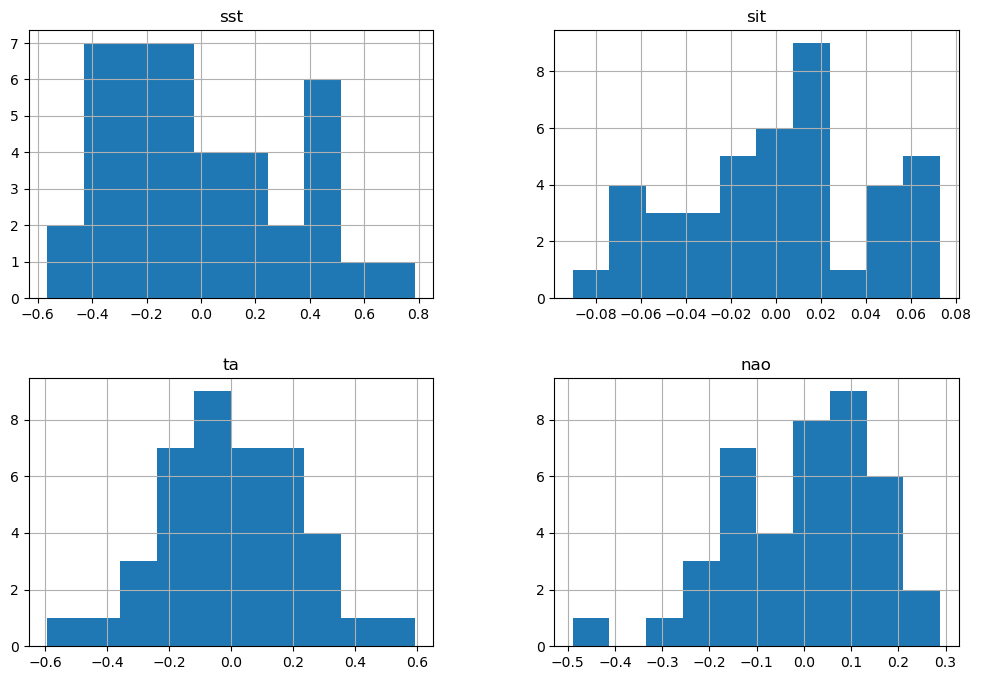

In [10]:
df.hist(figsize=(12,8))

---> sit predictor range is one magnitude smaller than for other predictors

### Predictive Modeling

#### X-y-split

In [11]:
X = df.drop('nao', axis=1)
y = df.nao

array([[<AxesSubplot:title={'center':'sst'}>,
        <AxesSubplot:title={'center':'sit'}>],
       [<AxesSubplot:title={'center':'ta'}>, <AxesSubplot:>]],
      dtype=object)

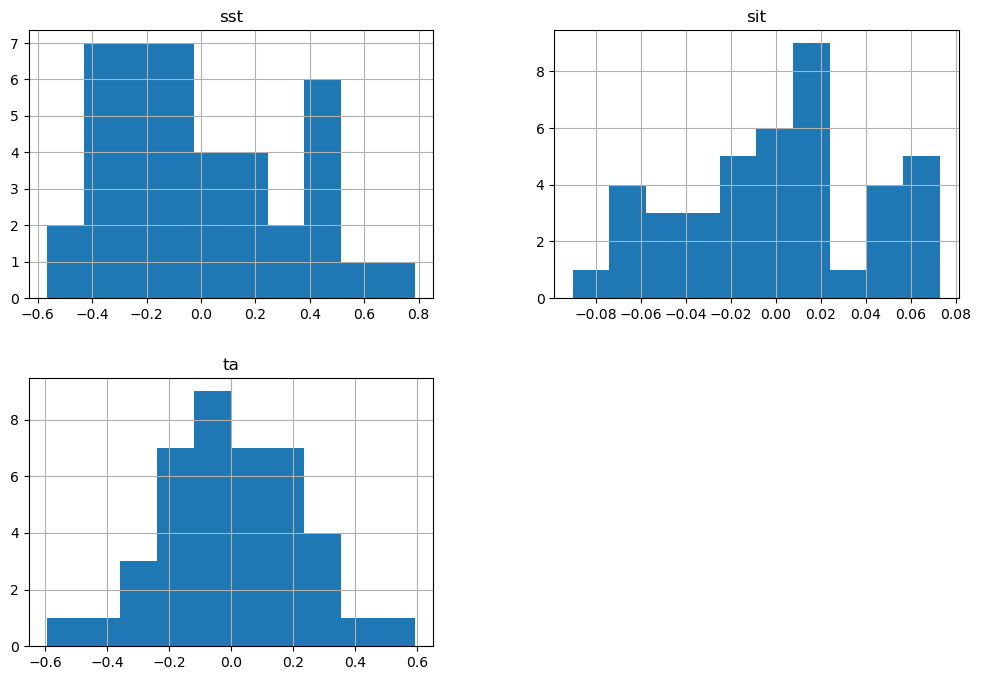

In [12]:
X.hist(figsize=(12,8))

#### Data Splitting

In [13]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=.30,random_state=123)

### Standardize

In [14]:
std_scaler=StandardScaler().fit(X_train)   ##. finding the parameters ( mean, variance from the training set )

X_train_scaled=std_scaler.transform(X_train)

In [15]:
X_train.shape

(28, 3)

In [16]:
X_test_scaled=std_scaler.transform(X_test)

In [17]:
X_test_scaled

array([[-0.27087875, -1.73786708, -0.93785911],
       [-2.16023766,  0.92262332,  1.40513276],
       [-1.44912738, -0.52591906,  3.6347315 ],
       [-0.48817225,  1.32213274,  2.25200701],
       [ 1.34657839, -0.61956743, -0.09569547],
       [-1.37308159, -1.3950779 ,  0.30331051],
       [ 0.81669474, -0.96081983, -0.07384232],
       [-1.57240974,  1.60026669, -0.6308535 ],
       [-0.71373532, -0.73336276,  0.19552374],
       [ 1.5760294 ,  0.37616872,  1.15065237],
       [-2.08143025, -1.491616  ,  1.90798753],
       [-0.54361973,  0.10964288, -3.47740006],
       [ 2.75373647, -0.51471198, -2.17575088]])

### Modeling using Statsmodels

In [18]:
X_train_const_scaled = sm.add_constant(X_train_scaled) # adding a constant

In [19]:
model = sm.OLS(y_train, X_train_const_scaled).fit()
predictions_train = model.predict(X_train_const_scaled) 

In [20]:
X_test_const_scaled = sm.add_constant(X_test_scaled) # adding a constant

In [21]:
predictions_test = model.predict(X_test_const_scaled) 
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                    nao   R-squared:                       0.226
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     2.339
Date:                Fri, 18 Nov 2022   Prob (F-statistic):             0.0988
Time:                        14:15:29   Log-Likelihood:                 13.413
No. Observations:                  28   AIC:                            -18.83
Df Residuals:                      24   BIC:                            -13.50
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0143      0.031     -0.467      0.6

In [22]:
predictions_test

array([-0.11393463,  0.16486718,  0.02696976,  0.0982487 , -0.12973334,
       -0.0315763 , -0.1231966 ,  0.17958885, -0.02386011, -0.07747463,
       -0.00055354,  0.02661485, -0.19828915])

### Modeling using Scikit Learn

#### Fitting

In [23]:
model=LinearRegression()    # model
model.fit(X_train_scaled, y_train)   # model train

LinearRegression()

In [24]:
X_train.columns

Index(['sst', 'sit', 'ta'], dtype='object')

In [25]:
model.coef_

array([-0.05520639,  0.06650086, -0.00103618])

In [26]:
model.intercept_

-0.014291002348597563

#### Making prediction

In [27]:
y_pred=model.predict(X_test_scaled)   # model prediction

y_pred_train=model.predict(X_train_scaled)

In [28]:
y_pred

array([-0.11393463,  0.16486718,  0.02696976,  0.0982487 , -0.12973334,
       -0.0315763 , -0.1231966 ,  0.17958885, -0.02386011, -0.07747463,
       -0.00055354,  0.02661485, -0.19828915])

In [29]:
y_test

27    0.100766
12    0.188450
11    0.144223
35    0.098404
10    0.037408
5    -0.156925
1    -0.154986
6    -0.127978
39    0.207359
26    0.097792
38   -0.005549
20   -0.138873
23   -0.095001
Name: nao, dtype: float64

### Evaluating Model Performance

In [30]:
result=pd.DataFrame({"y_test":y_test,"y_pred":y_pred})

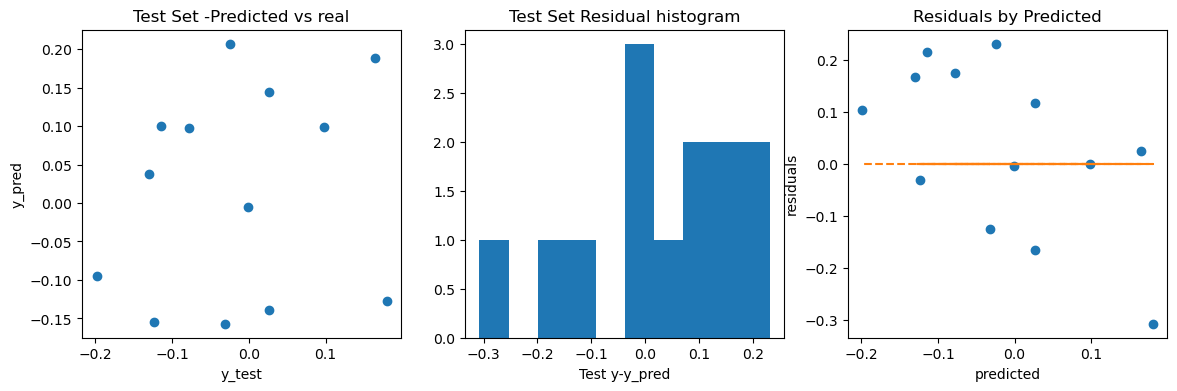

In [31]:
# Make an scatter plot y_pred vs y

fig, ax = plt.subplots(1,3,figsize=(14,4))
ax[0].plot(y_pred, y_test, 'o')
ax[0].set_xlabel("y_test")
ax[0].set_ylabel("y_pred")
ax[0].set_title("Test Set -Predicted vs real")

# Get a histogram of the residuals ie: y - y_pred.  Homoscdasticity
# It resembles a normal distribution?
ax[1].hist(y_test - y_pred)
ax[1].set_xlabel("Test y-y_pred")
ax[1].set_title("Test Set Residual histogram")

ax[2].plot(y_pred,y_test - y_pred,"o")
ax[2].set_xlabel("predicted")
ax[2].set_ylabel("residuals")
ax[2].set_title("Residuals by Predicted")
ax[2].plot(y_pred,np.zeros(len(y_pred)),linestyle='dashed')

<AxesSubplot:xlabel='y_pred', ylabel='y_test'>

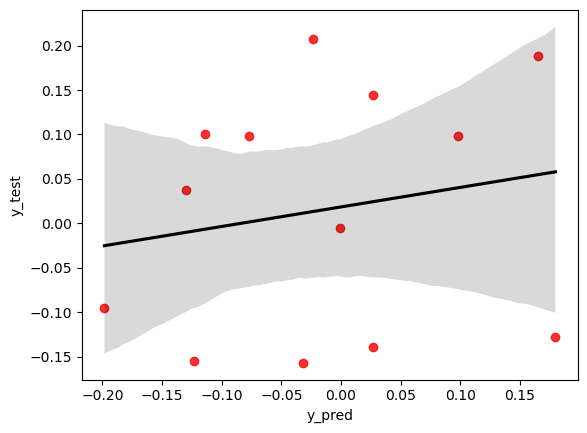

In [32]:
sns.regplot(x='y_pred',y='y_test', data=result, scatter_kws={"color": "red"}, line_kws={"color": "black"})

#### Error metrics

In [33]:
print(mse(y_test,y_pred))
print(mae(y_test,y_pred))

0.024762934578147995
0.1282921471187448


In [34]:
##prediction on the train set
mse(y_train,y_pred_train)

0.022462165512557454

In [35]:
R2=r2_score(y_test,y_pred)
R2

-0.45961340474000956

In [36]:
R2_test=model.score(X_test_scaled,y_test)
R2_train=model.score(X_train_scaled,y_train)
print("test R2 is",R2_test,", train R2 is",R2_train)

test R2 is -0.45961340474000956 , train R2 is 0.22625471153883325


In [37]:
Adj_R2= 1 - (1-R2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)
Adj_R2

-0.9461512063200128

#### Feature importance

In [43]:
features_importances = pd.DataFrame(data={
    'Attribute': X_train.columns,
    'Importance': model.coef_
})
features_importances = features_importances.sort_values(by='Importance', ascending=False)

In [44]:
features_importances

,Attribute,Importance
1,sit,0.066501
2,ta,-0.001036
0,sst,-0.055206


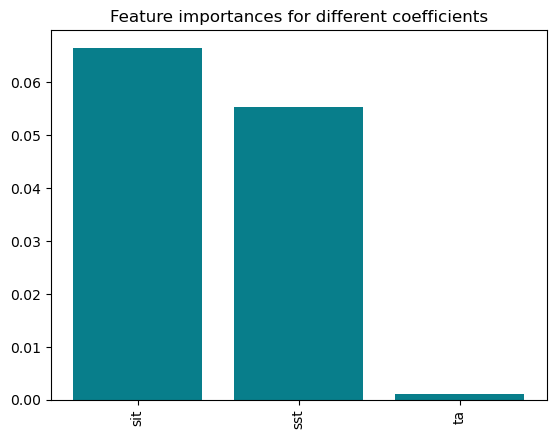

In [40]:
plt.bar(x=features_importances['Attribute'], height=features_importances['Importance'], color='#087E8B')
plt.title('Feature importances for different coefficients', size=12)
plt.xticks(rotation='vertical')
plt.show()